# **Wstęp**
---
Niniejszy projekt skupia się na implementacji problemu CVRP (Capacitated Vehicle Routing Problem) z wykorzystaniem dwóch podejść: programowania liniowego całkowitoliczbowego (MIP) z biblioteką PuLP oraz algorytmu Clarke-Wright Savings. CVRP to problem optymalizacji tras dla floty pojazdów o ograniczonej pojemności, które mają dostarczyć towary do określonej liczby klientów. Celem jest minimalizacja kosztów tras, przy jednoczesnym spełnieniu ograniczeń dotyczących pojemności pojazdów oraz wymagań klientów.

Problem ten jest rozwinięciem klasycznego problemu komiwojażera (TSP), gdzie dodatkowym ograniczeniem jest pojemność pojazdów. W projekcie przedstawione zostaną dwa różne podejścia do jego rozwiązania:

* Mixed Integer Programming (MIP): Matematyczne modelowanie problemu przy użyciu programowania liniowego całkowitoliczbowego, z wykorzystaniem biblioteki PuLP, pozwala na precyzyjne rozwiązanie problemu, minimalizując całkowity koszt tras.

* Algorytm Clarke-Wright Savings: Metoda heurystyczna, która szybko generuje dobre rozwiązania, minimalizując dystanse tras poprzez łączenie ich na podstawie oszczędności wynikających z odległości.

Projekt ma na celu porównanie tych dwóch metod pod kątem ich efektywności oraz przydatności w różnych scenariuszach optymalizacji tras logistycznych.

In [ ]:
# Instalacja brakujących bibliotek
pip install osmnx pulp

In [ ]:
# Import bibliotek
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import pulp

In [ ]:
# Funkcja do geokodowania adresów
def geocode_addresses(addresses):
    return [ox.geocode(address) for address in addresses]


# Obliczanie odległości między punktami
def calculate_distance(G, point1, point2):
    origin_node = ox.distance.nearest_nodes(G, point1[1], point1[0])
    destination_node = ox.distance.nearest_nodes(G, point2[1], point2[0])
    try:
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')
        route_gdf = ox.routing.route_to_gdf(G, route)
        length = sum(float(length) for length in route_gdf['length'])
        return round(length / 1000, 2)
    except nx.NetworkXNoPath:
        return float('inf')

# Funkcja do generowania losowych kolorów
def generate_random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

# Funkcja poprawia wynik - trasa zaczyna się i kończy w magazynie
def get_routes_from_solution(x, num_vehicles, num_points):
    routes = []
    visited_points = set()
    for v in range(num_vehicles):
        route = [0]  # zaczynamy od magazynu
        current_point = 0
        while True:
            next_point = [j for j in range(num_points) if pulp.value(x[current_point, j]) == 1 and j not in visited_points]
            if not next_point or next_point[0] == 0:  # jeśli brak kolejnego punktu lub powrót do magazynu
                break
            next_point = next_point[0]
            visited_points.add(next_point)
            route.append(next_point)
            current_point = next_point
        route.append(0)  # kończymy w magazynie
        routes.append(route)
    return routes


Lokalizacje użyte w tym projekcie dotyczą fikcyjnej firmy zajmującej się dystrybucją towarów, której magazyn mieści się na obrzeżach Wrocławia. Firma obsługuje kilkanaście sklepów zlokalizowanych na terenie Wrocławia oraz w powiecie wrocławskim. Celem optymalizacji tras jest zminimalizowanie kosztów dostaw z magazynu do tych punktów sprzedaży, przy jednoczesnym spełnieniu ograniczeń pojemności pojazdów.

In [ ]:
# Adresów marketów
market_addresses = [
    'Rynek, Wrocław, Polska',
    'Ostrów Tumski, Wrocław, Polska',
    'Hala Stulecia, Wrocław, Polska',
    'Smolec, Polska',
    'Kąty Wrocławskie, Polska',
    'Sobótka, Polska',
    'Jordanów Śląski, Polska',
    'Długołęka, Polska',
    'Kobierzyce, Polska',
    'Mędłów, Polska',
    'Żórawina, Polska',
    'Wysoka, Wrocław,  Polska',
    'Siechnice, Polska',
    'Iwiny, Polska',
    'Leśnica, Wrocław,  Polska'
]

# Adres magazynu
warehouse_address = 'Bielany Wrocławskie, Polska'

# Geokodowanie
market_points = geocode_addresses(market_addresses)
warehouse_point = ox.geocode(warehouse_address)

In [ ]:
# Pobieranie granic i sieci drogowych
powiat = ox.geocode_to_gdf('powiat wrocławski, Polska')
wroclaw = ox.geocode_to_gdf('Wrocław, Polska')
combined_geometry = gpd.GeoDataFrame(geometry=powiat.geometry.union(wroclaw.geometry))
G = ox.graph_from_polygon(combined_geometry.geometry[0], network_type='drive')


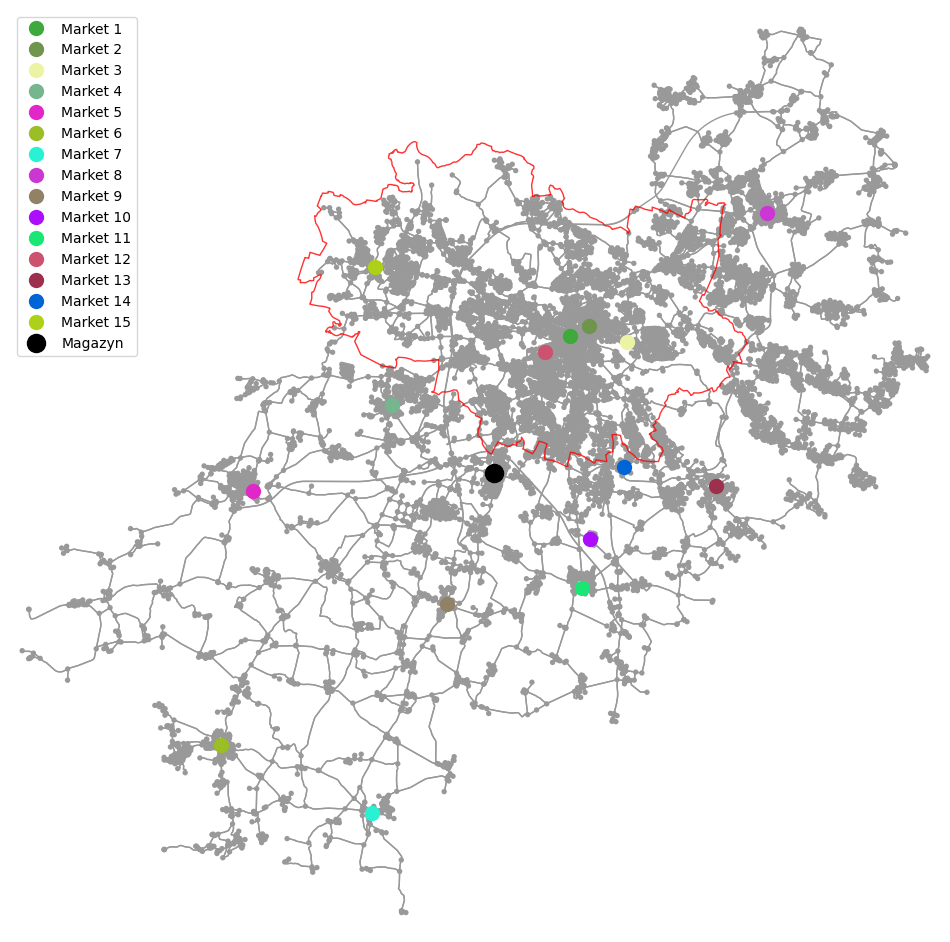

In [ ]:
# Rysowanie mapy
fig, ax = ox.plot_graph(G, node_color='#999999', edge_color='#999999', bgcolor='w', figsize=(12, 12), show=False, close=False)
wroclaw.plot(ax=ax, facecolor='none', edgecolor='#FF0000', alpha=0.8)

for i, point in enumerate(market_points):
    ax.plot(point[1], point[0], 'o', color=generate_random_color(), markersize=10, label=f'Market {i + 1}')

ax.plot(warehouse_point[1], warehouse_point[0], 'o', color='black', markersize=13, label='Magazyn')

nodes, edges = ox.graph_to_gdfs(G)
x_values = nodes['x'].tolist() + [point[1] for point in market_points] + [warehouse_point[1]]
y_values = nodes['y'].tolist() + [point[0] for point in market_points] + [warehouse_point[0]]

ax.set_xlim(min(x_values) - 0.01, max(x_values) + 0.01)
ax.set_ylim(min(y_values) - 0.01, max(y_values) + 0.01)
ax.legend()
plt.show()


W symulacji uwzględniono zapotrzebowania marketów na towary. Każdy z marketów, zlokalizowanych w różnych częściach Wrocławia i powiatu wrocławskiego, ma określone dzienne zapotrzebowanie, które musi zostać pokryte przez dostawy z magazynu. Wartości te zostały wygenerowane w sposób losowy, aby zasymulować rzeczywiste scenariusze logistyczne.

In [ ]:
# Zapotrzebowanie w PAL
num_markets = len(market_points)
demand = np.array([random.randint(2, 18) for _ in range(num_markets)])
warehouse_demand = 0
demands = np.append(warehouse_demand, demand)
total_demand = sum(demand)
vehicle_capacity= 33
num_tirs = math.ceil(total_demand / vehicle_capacity)

print("Zapotrzebowanie:", demand)
print("Suma zapotrzebowania:", total_demand)
print("Ilość potrzebnych TIRów:", num_tirs)

Zapotrzebowanie: [17  2 13  7  3 18 17 15 12  3  8  9  2 10  7]
Suma zapotrzebowania: 143
Ilość potrzebnych TIRów: 5


In [ ]:
# Macierz odległości
n_point = num_markets + 1  # Dodajemy 1 dla magazynu
distance_matrix = np.zeros((n_point, n_point))

for i in range(num_markets):
    distance = calculate_distance(G, warehouse_point, market_points[i])
    distance_matrix[0, i+1] = distance_matrix[i+1, 0] = distance

for i in range(num_markets):
    for j in range(i + 1, num_markets):
        distance = calculate_distance(G, market_points[i], market_points[j])
        distance_matrix[i+1, j+1] = distance_matrix[j+1, i+1] = distance

labels = ['Magazyn'] + [f'Market {i + 1}' for i in range(num_markets)]
distance_df = pd.DataFrame(distance_matrix, index=labels, columns=labels)
distances = distance_df.values

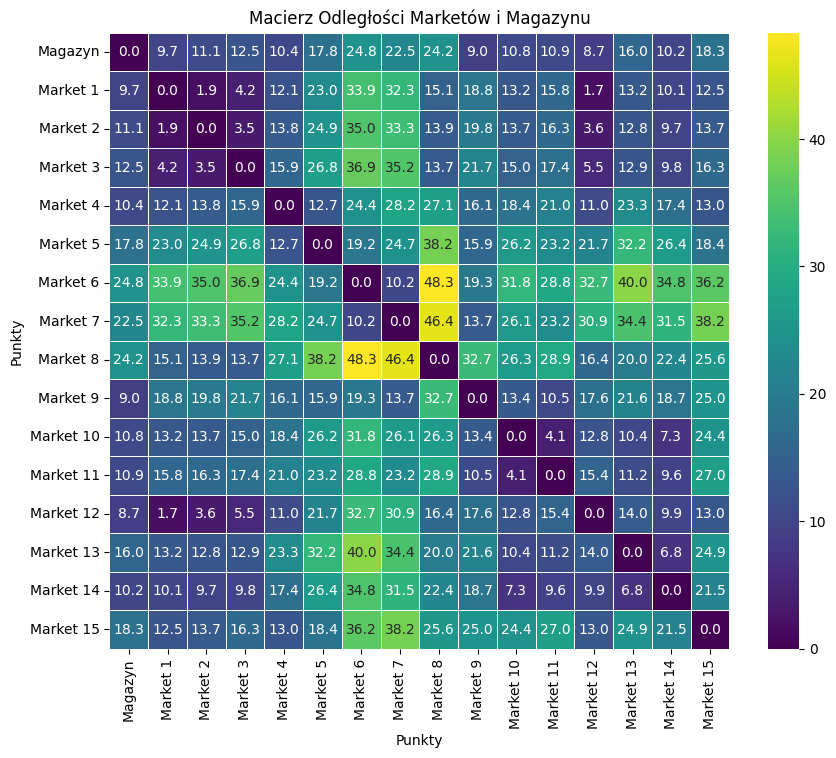

In [ ]:
# Rysowanie heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5)
plt.title("Macierz Odległości Marketów i Magazynu")
plt.xlabel("Punkty")
plt.ylabel("Punkty")
plt.show()

# Zastosowanie PuLP w CVRP #
---
PuLP to biblioteka Python, która umożliwia rozwiązywanie problemów optymalizacji liniowej i całkowitoliczbowej. W kontekście problemu CVRP (Capacitated Vehicle Routing Problem), PuLP pozwala na stworzenie matematycznego modelu problemu oraz jego rozwiązanie przy użyciu solverów optymalizacyjnych.

W modelowaniu CVRP przy pomocy PuLP kluczowe jest zdefiniowanie kilku elementów:
1. **Zmienne decyzyjne**: Każda zmienna odpowiada trasie, która łączy dwa punkty — sklep i magazyn — i przyjmuje wartość 1, jeśli trasa ta jest częścią rozwiązania, lub 0, jeśli nie jest.
2. **Funkcja celu**: Celem jest minimalizacja kosztów transportu, najczęściej wyrażonych jako suma dystansów między punktami. Funkcja celu zdefiniowana w PuLP ma za zadanie zminimalizować łączną długość tras wszystkich pojazdów.
3. **Ograniczenia**: W CVRP mamy kilka podstawowych ograniczeń:
   - Każdy pojazd ma ograniczoną pojemność i nie może przewozić więcej towarów niż jego maksymalna pojemność.
   - Każdy sklep musi zostać odwiedzony dokładnie raz przez jeden pojazd.
   - Każdy pojazd musi rozpocząć i zakończyć trasę w magazynie.

Dzięki bibliotece PuLP można w łatwy sposób zdefiniować powyższe elementy i uruchomić solver (np. CBC) w celu znalezienia optymalnego rozwiązania. PuLP przekształca problem w zestaw równań i nierówności, które solver przetwarza, szukając najlepszej kombinacji tras dla pojazdów. W tym projekcie metoda MIP dostarcza optymalnych wyników, ale jej obliczeniowy koszt rośnie wraz ze skalą problemu.


In [ ]:
# Definicja problemu
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

# Zmienne decyzyjne
trasa = pulp.LpVariable.dicts('trasa', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
tir = pulp.LpVariable.dicts('tir', range(1, num_tirs + 1), lowBound=0, upBound=1, cat='Binary')

# Funkcja celu
problem += pulp.lpSum(distances[i, j] * trasa[i, j] for i in range(n_point) for j in range(n_point))

# Ograniczenia
# Zapobiega bezpośrednim połączeniom punktu z samym sobą.
for i in range(n_point):
    problem += trasa[i, i] == 0

# Zapewnia, że każde połączenie używane jest dokładnie raz.
for i in range(1, n_point):  # Punkt 0 to magazyn, więc zaczynamy od 1
    problem += pulp.lpSum(trasa[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(trasa[i, j] for j in range(n_point)) == 1

# Zapewnia, że każda używana ciężarówka opuszcza i wraca do magazynu.
for k in range(1, num_tirs + 1):
    problem += pulp.lpSum(trasa[0, j] for j in range(1, n_point)) >= tir[k]
    problem += pulp.lpSum(trasa[j, 0] for j in range(1, n_point)) >= tir[k]

problem += pulp.lpSum(trasa[i, 0] for i in range(1, n_point)) == num_tirs
problem += pulp.lpSum(trasa[0, i] for i in range(1, n_point)) == num_tirs
problem += pulp.lpSum(tir[k] for k in range(1, num_tirs + 1)) == num_tirs

# Eliminacja subtourów
subtours = []
for length in range(2, n_point):
    subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [trasa[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

# Rozwiązanie problemu
status = problem.solve()

In [ ]:
# Uzyskania tras z rozwiązania problemu
routes = get_routes_from_solution(trasa, num_tirs, n_point)
routes

[[0, 3, 8, 2, 0],
 [0, 4, 5, 6, 0],
 [0, 7, 9, 0],
 [0, 11, 10, 13, 14, 0],
 [0, 12, 1, 15, 0]]

<ipython-input-34-e3f9757c1011>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


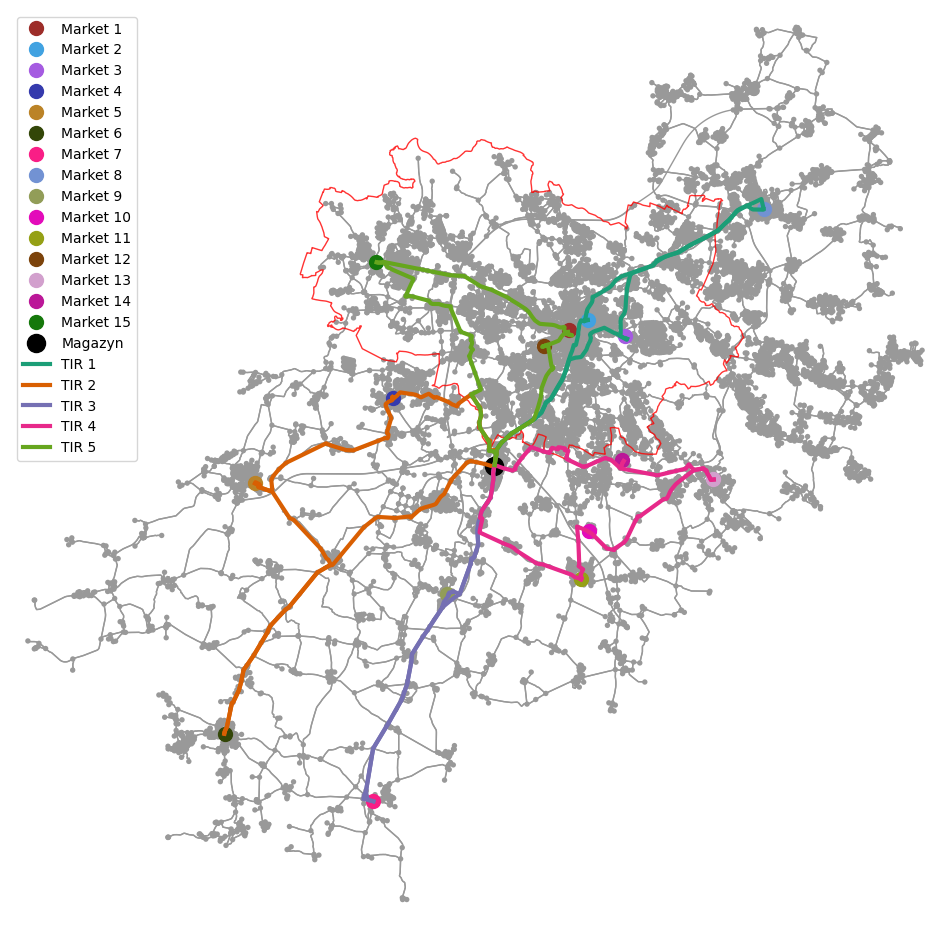

In [ ]:
# Rysowanie wyników tras na mapie OSMnx
fig, ax = ox.plot_graph(G, node_color='#999999', edge_color='#999999', bgcolor='w', figsize=(12, 12), show=False, close=False)
wroclaw.plot(ax=ax, facecolor='none', edgecolor='#FF0000', alpha=0.8)

# Rysowanie punktów marketów i magazynu
for i, point in enumerate(market_points):
    ax.plot(point[1], point[0], 'o', color=generate_random_color(), markersize=10, label=f'Market {i + 1}')

ax.plot(warehouse_point[1], warehouse_point[0], 'o', color='black', markersize=13, label='Magazyn')

# Rysowanie tras dla każdego TIR-a
cmap = cm.get_cmap('Dark2')
used_labels = set()
for v, vehicle_route in enumerate(routes):
    if len(vehicle_route) < 2:
        continue  # Pomijanie tras, które nie mają przynajmniej dwóch punktów (w tym magazynu)
    for i in range(len(vehicle_route) - 1):
        point1 = market_points[vehicle_route[i] - 1] if vehicle_route[i] != 0 else warehouse_point
        point2 = market_points[vehicle_route[i + 1] - 1] if vehicle_route[i + 1] != 0 else warehouse_point
        origin_node = ox.distance.nearest_nodes(G, point1[1], point1[0])
        destination_node = ox.distance.nearest_nodes(G, point2[1], point2[0])
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
        route_line = list(zip(*route_coords))

        label = f'TIR {v + 1}'
        if label not in used_labels:
            ax.plot(route_line[1], route_line[0], color=cmap(v), linewidth=3, label=label)
            used_labels.add(label)
        else:
            ax.plot(route_line[1], route_line[0], color=cmap(v), linewidth=3)

ax.legend()
plt.show()

In [ ]:
# Lista dla statystyk
route_stats = []

# Obliczanie statystyki dla każdej trasy
for v, vehicle_route in enumerate(routes):
    num_markets = len(vehicle_route) - 2  # Bez uwzględniania magazynu jako początkowego i końcowego punktu

    total_pallets = sum(demands[j] for j in vehicle_route if j != 0)

    route_length = 0
    route_time = 0
    for i in range(len(vehicle_route) - 1):
        point1 = market_points[vehicle_route[i] - 1] if vehicle_route[i] != 0 else warehouse_point
        point2 = market_points[vehicle_route[i + 1] - 1] if vehicle_route[i + 1] != 0 else warehouse_point
        origin_node = ox.distance.nearest_nodes(G, point1[1], point1[0])
        destination_node = ox.distance.nearest_nodes(G, point2[1], point2[0])
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')

        # Konwersja trasy na GeoDataFrame i pobranie długości krawędzi
        route_gdf = ox.convert.graph_to_gdfs(G.subgraph(route), nodes=False)
        edge_lengths = route_gdf['length'].sum()
        route_length += edge_lengths

        route_time += edge_lengths / 50000 * 60  # Przekształcenie na minuty

    route_stats.append({
        'TIR': v + 1,
        'Liczba Marketów': num_markets,
        'Łączna Liczba Palet': total_pallets,
        'Długość Trasy (km)': round(route_length / 1000, 1),  # Przekształcenie na km
        'Czas Trasy (minuty)': round(route_time, 1)
    })

# Tworzenie DataFrame
df_stats = pd.DataFrame(route_stats)

# Wyświetlanie DataFrame
display(df_stats)

,TIR,Liczba Marketów,Łączna Liczba Palet,Długość Trasy (km),Czas Trasy (minuty)
0,1,3,30,60.5,72.6
1,2,3,28,131.2,157.5
2,3,2,29,89.2,107.1
3,4,4,23,83.3,99.9
4,5,3,33,65.1,78.1


# Opis metody Clarke-Wright Savings #
---
Algorytm Clarke-Wright Savings to jedna z najpopularniejszych heurystycznych metod rozwiązywania problemów typu Vehicle Routing Problem (VRP), w tym również Capacitated Vehicle Routing Problem (CVRP). Metoda ta jest znana ze swojej prostoty i efektywności w generowaniu rozwiązań, które choć nie zawsze są optymalne, to w wielu przypadkach są bliskie optymalnym rozwiązaniom przy znacznie mniejszych kosztach obliczeniowych.

Podstawowe kroki algorytmu Clarke-Wright są następujące:
1. **Początkowe rozwiązanie**: Na początku zakłada się, że każdy sklep jest obsługiwany przez oddzielną trasę, gdzie pojazd jedzie z magazynu do sklepu i wraca z powrotem.
2. **Obliczanie oszczędności**: Następnie dla każdej pary sklepów oblicza się „oszczędności”, które wynikają z łączenia dwóch tras w jedną. Oszczędności są definiowane jako różnica między sumą odległości z magazynu do dwóch sklepów i bezpośrednim połączeniem tych sklepów, co skraca dystans do pokonania.
   - **Sij = C(magazyn → i) + C(magazyn → j) − C(i → j)**  
     Gdzie \( Sij \) to oszczędności z połączenia tras, a \( C(a → b) \) to koszt trasy z punktu \( a \) do punktu \( b \).
3. **Łączenie tras**: Na podstawie obliczonych oszczędności algorytm łączy trasy w taki sposób, aby maksymalizować te oszczędności, przestrzegając jednocześnie ograniczeń związanych z pojemnością pojazdów.
4. **Kontrola ograniczeń**: Po każdej operacji łączenia sprawdza się, czy pojemność pojazdu nie została przekroczona, a także, czy wszystkie sklepy są odwiedzane tylko raz.

Metoda Clarke-Wright Savings pozwala na szybkie rozwiązanie problemu dla dużych instancji CVRP, jednakże jej wyniki mogą być suboptymalne, szczególnie w przypadkach o skomplikowanej topologii tras. W praktyce, metoda ta jest często wykorzystywana ze względu na swoją skalowalność oraz możliwość dostarczenia rozwiązań w krótkim czasie, co jest szczególnie przydatne w dynamicznych systemach logistycznych, gdzie czas na przetwarzanie danych jest ograniczony.


In [ ]:
def clarke_wright_savings(demands, distance_matrix, vehicle_capacity):
    num_markets = len(demands) - 1
    savings = []
    for i in range(1, num_markets + 1):
        for j in range(i + 1, num_markets + 1):
            save = distance_matrix[0][i] + distance_matrix[0][j] - distance_matrix[i][j]
            savings.append((save, i, j))
    savings.sort(reverse=True)

    routes = [[i] for i in range(1, num_markets + 1)]
    route_loads = {i: demands[i] for i in range(1, num_markets + 1)}

    for save, i, j in savings:
        route_i = None
        route_j = None
        for route in routes:
            if route[0] == i:
                route_i = route
            if route[-1] == j:
                route_j = route
        if route_i is not None and route_j is not None and route_i != route_j:
            if route_loads[route_i[0]] + route_loads[route_j[0]] <= vehicle_capacity:
                route_i.extend(route_j)
                route_loads[route_i[0]] += route_loads[route_j[0]]
                routes.remove(route_j)

    routes = [[0] + route + [0] for route in routes]
    return routes

# Wstępna optymalizacja tras za pomocą algorytmu Clarke'a-Wrighta
initial_routes = clarke_wright_savings(demands, distance_matrix, vehicle_capacity)



In [ ]:
initial_routes

[[0, 2, 3, 8, 0],
 [0, 4, 1, 12, 0],
 [0, 5, 6, 15, 0],
 [0, 7, 9, 0],
 [0, 10, 11, 13, 14, 0]]

<ipython-input-38-e220fec8ab91>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


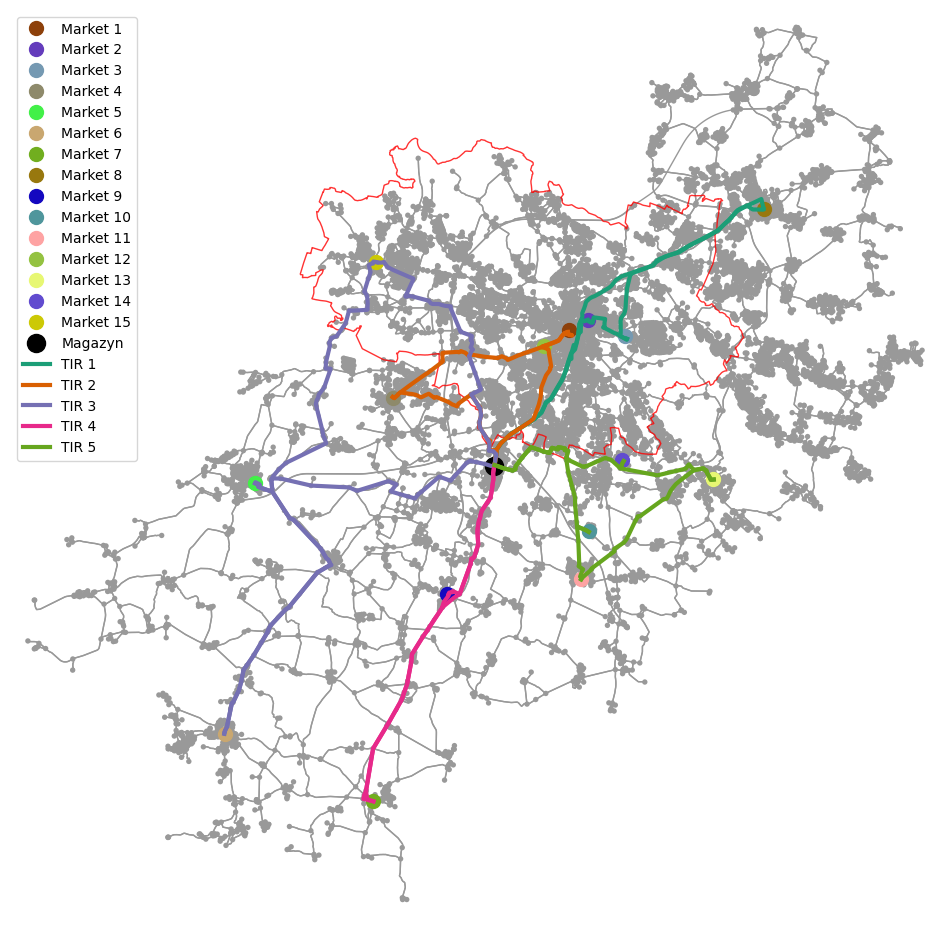

In [ ]:
# Rysowanie wyników tras na mapie OSMnx
fig, ax = ox.plot_graph(G, node_color='#999999', edge_color='#999999', bgcolor='w', figsize=(12, 12), show=False, close=False)
wroclaw.plot(ax=ax, facecolor='none', edgecolor='#FF0000', alpha=0.8)

# Rysowanie punktów marketów i magazynu
for i, point in enumerate(market_points):
    ax.plot(point[1], point[0], 'o', color=generate_random_color(), markersize=10, label=f'Market {i + 1}')

ax.plot(warehouse_point[1], warehouse_point[0], 'o', color='black', markersize=13, label='Magazyn')

# Rysowanie tras dla każdego TIR-a
cmap = cm.get_cmap('Dark2')
used_labels = set()
for v, vehicle_route in enumerate(initial_routes):
    if len(vehicle_route) < 2:
        continue  # Pomijanie tras, które nie mają przynajmniej dwóch punktów (w tym magazynu)
    for i in range(len(vehicle_route) - 1):
        point1 = market_points[vehicle_route[i] - 1] if vehicle_route[i] != 0 else warehouse_point
        point2 = market_points[vehicle_route[i + 1] - 1] if vehicle_route[i + 1] != 0 else warehouse_point
        origin_node = ox.distance.nearest_nodes(G, point1[1], point1[0])
        destination_node = ox.distance.nearest_nodes(G, point2[1], point2[0])
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
        route_line = list(zip(*route_coords))

        label = f'TIR {v + 1}'
        if label not in used_labels:
            ax.plot(route_line[1], route_line[0], color=cmap(v), linewidth=3, label=label)
            used_labels.add(label)
        else:
            ax.plot(route_line[1], route_line[0], color=cmap(v), linewidth=3)

ax.legend()
plt.show()

In [ ]:
# Lista dla statystyk
route_stats = []

# Obliczanie statystyki dla każdej trasy
for v, vehicle_route in enumerate(initial_routes):
    num_markets = len(vehicle_route) - 2  # Bez uwzględniania magazynu jako początkowego i końcowego punktu

    total_pallets = sum(demands[j] for j in vehicle_route if j != 0)

    route_length = 0
    route_time = 0
    for i in range(len(vehicle_route) - 1):
        point1 = market_points[vehicle_route[i] - 1] if vehicle_route[i] != 0 else warehouse_point
        point2 = market_points[vehicle_route[i + 1] - 1] if vehicle_route[i + 1] != 0 else warehouse_point
        origin_node = ox.distance.nearest_nodes(G, point1[1], point1[0])
        destination_node = ox.distance.nearest_nodes(G, point2[1], point2[0])
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')

        # Konwersja trasy na GeoDataFrame i pobranie długości krawędzi
        route_gdf = ox.convert.graph_to_gdfs(G.subgraph(route), nodes=False)
        edge_lengths = route_gdf['length'].sum()
        route_length += edge_lengths

        route_time += edge_lengths / 50000 * 60  # Przekształcenie na minuty

    route_stats.append({
        'TIR': v + 1,
        'Liczba Marketów': num_markets,
        'Łączna Liczba Palet': total_pallets,
        'Długość Trasy (km)': round(route_length / 1000, 1),  # Przekształcenie na km
        'Czas Trasy (minuty)': round(route_time, 1)
    })

# Tworzenie DataFrame
df_stats = pd.DataFrame(route_stats)

# Wyświetlanie DataFrame
display(df_stats)

,TIR,Liczba Marketów,Łączna Liczba Palet,Długość Trasy (km),Czas Trasy (minuty)
0,1,3,30,61.7,74.1
1,2,3,33,54.3,65.1
2,3,3,28,177.4,212.8
3,4,2,29,89.2,107.1
4,5,4,23,84.5,101.3


#Podsumowanie i Wnioski#
---
Oba podejścia do rozwiązania problemu CVRP — MIP oraz algorytm Clarke-Wright — mają swoje zalety. MIP daje dokładne rozwiązania, ale jest obliczeniowo wymagający, szczególnie dla dużych instancji problemu. Metoda Clarke-Wright jest szybsza, ale może dostarczać rozwiązania bliskie optymalnym, lecz nie zawsze idealne. W zależności od skali problemu i potrzeb praktycznych, wybór metody może się różnić. W projekcie pokazano, jak obie techniki mogą współdziałać, oferując różne podejścia do rozwiązania złożonych problemów logistycznych.